In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()

In [ ]:
import pandas as pd
import math
from surprise import Dataset
from surprise import Reader
import matplotlib.pyplot as plt
import numpy as np
from surprise import accuracy
from sklearn.metrics import confusion_matrix
from surprise import KNNWithMeans, KNNBaseline, KNNBasic, SVDpp, SlopeOne, NMF, NormalPredictor, KNNWithZScore, BaselineOnly, CoClustering, SVD
from surprise.model_selection import cross_validate


In [ ]:
dfo = pd.read_csv("/content/drive/MyDrive/Comp/Export2v2v3.csv")

In [ ]:
#Generate List of Unique Values for UserID, Type, Competency
type_List = dfo['type'].unique().tolist()
user_List = dfo['CustID'].unique().tolist()
competency_List = dfo['competency'].unique().tolist()

print(competency_List)
print(type_List)
print(user_List)

['SelfAwareness', 'SelfManagement', 'ResponsibleDecisionMaking', 'CheckInContribution', 'SocialAwareness', 'RelationshipSkills']
['AYK', 'ASK', 'ACT', 'BLOG']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [ ]:
oversampler = RandomOverSampler(sampling_strategy=0.2)
masdas = df_oversampled, y_oversampled = oversampler.fit_resample(dfo, dfo['rating'])

In [ ]:
X = dfo.drop('rating', axis=1)
y = dfo['rating']

# Oversample the data
oversampler = RandomOverSampler(sampling_strategy=0.2)
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Create a new DataFrame combining the original and oversampled data
df_oversampled = pd.concat([X, y], axis=1)
df_oversampled = df_oversampled.append(pd.DataFrame(data=X_oversampled, columns=X.columns))
df_oversampled['rating'] = y_oversampled

In [ ]:
dfo = df_oversampled

In [ ]:
dfo.rating.value_counts(normalize=False)

In [ ]:
df_comp = dfo[['CustID','competency','rating']]
df_type = dfo[['CustID','type','rating']]
df_resource = dfo[['CustID','resource_id','rating']]
reader = Reader(rating_scale=(0, 1))

See which model type has the highest RMSE

In [ ]:
reader = Reader(rating_scale=(0, 1))
data_comp = Dataset.load_from_df(df_comp[["CustID", "competency", "rating"]], reader)
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_comp, measures=['RMSE'], cv=3, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Train Models

In [ ]:
#Competency Model
data_comp = Dataset.load_from_df(df_comp[["CustID", "competency", "rating"]], reader)
trainset = data_comp.build_full_trainset()
sim_options = {
      "name": "cosine",
      "user_based": True,
      "k" : 5
  }
  # Create the algorithm
algo = KNNWithMeans(sim_options=sim_options)

  # Train the algorithm on the training set
algo.fit(trainset)


#Competency Model
data_comp = Dataset.load_from_df(df_type[["CustID", "type", "rating"]], reader)
trainset = data_comp.build_full_trainset()
sim_options = {
      "name": "cosine",
      "user_based": True,
      "k" : 5
  }
  # Create the algorithm
algo1 = KNNWithMeans(sim_options=sim_options)

  # Train the algorithm on the training set
algo1.fit(trainset)

Create Ranked Predictions

In [ ]:
type_List = dfo['type'].unique().tolist()
user_List = dfo['CustID'].unique().tolist()
competency_List = dfo['competency'].unique().tolist()
dfz = pd.DataFrame(columns=['UserID', 'Competency', 'Rating', 'ValueType'])

# Loop over users
for users in user_List:
    # Loop over competencies
    for comp in competency_List:
        # Predict the rating for the user and competency
        prediction = algo.predict(users, comp)
        # Extract the necessary information from the prediction object
        uid = prediction.uid
        iid = prediction.iid
        est = prediction.est
        # Append the prediction information to the dataframe
        dfz = dfz.append({'UserID': uid, 'Competency': iid, 'Rating': est, 'ValueType': 'Competency'}, ignore_index=True)

dfk = pd.DataFrame(columns=['UserID', 'Type', 'Rating', 'ValueType'])
for users in user_List:
    # Loop over content types
    for types in type_List:
        # Predict the rating for the user and competency
        prediction = algo1.predict(users, types)
        # Extract the necessary information from the prediction object
        uid = prediction.uid
        iid = prediction.iid
        est = prediction.est
        # Append the prediction information to the dataframe
        dfk = dfk.append({'UserID': uid, 'Type': iid, 'Rating': est, 'ValueType': "Type"}, ignore_index=True)

In [ ]:
DFK = dfk.sort_values(by=['UserID','Rating'], ascending=[True,False])

DFZ = dfz.sort_values(by=['UserID','Rating'], ascending=[True,False])

In [ ]:
from os import killpg
from surprise import KNNWithMeans, KNNBaseline, KNNBasic
from surprise.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#BaseLine Calculations

In [ ]:
df_Baseline = dfo[['rating']]
print(df_Baseline.value_counts(normalize=True))

print('BaseLine to Beat 88%')

rating
1         0.639405
0         0.360595
dtype: float64
BaseLine to Beat 88%


#Competency Model and Accuracy

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Accuracy 0.779


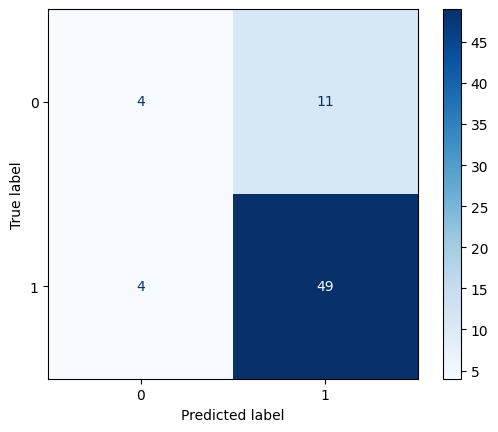

In [ ]:

# Load the data into a Dataset object
data_comp = Dataset.load_from_df(df_comp[["CustID", "competency", "rating"]], reader)
# Split the data into training and testing sets
trainset, testset = train_test_split(data_comp, test_size=0.3)
# Define the similarity options for the algorithm
sim_options = {
      "name": "cosine",
      "user_based": True,
      "k" : 5
  }
  # Create the algorithm
algo = KNNWithMeans(sim_options=sim_options)
  # Train the algorithm on the training set
algo.fit(trainset)
  # Test the algorithm on the testing set and get the predictions
predictions = algo.test(testset)
algo.fit(trainset)
# Test the algorithm on the testing set and get the predictions
predictions = algo.test(testset)
third_column = [row[2] for row in testset]
#print(third_column)
predicted_labels = [1 if prediction.est  > 0.5 else 0 for prediction in predictions]
from sklearn.metrics import accuracy_score
A = accuracy_score(third_column,predicted_labels, normalize=True)
print("Accuracy {:.3f}".format(A))
cm = confusion_matrix(third_column, predicted_labels)
cmap = 'Blues' 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)
plt.show()

#Type Model and Accuracy

Computing the cosine similarity matrix...
Done computing similarity matrix.
Accuracy 0.941


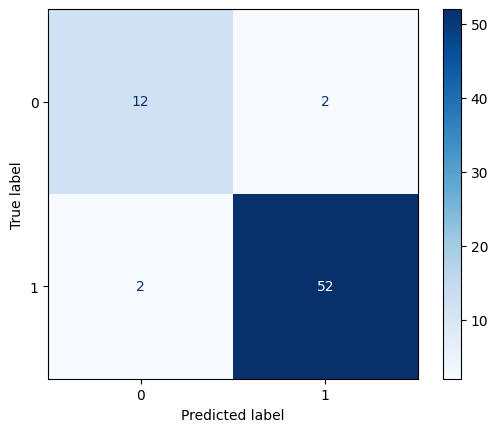

In [ ]:
# Load the data into a Dataset object
data_type = Dataset.load_from_df(df_type[["CustID", "type", "rating"]], reader)
# Split the data into training and testing sets
trainset, testset = train_test_split(data_type, test_size=0.3)
# Define the similarity options for the algorithm
sim_options = {
    "name": "cosine",
    "user_based": True,
    "k" : 5
}
# Create the algorithm
algo = KNNWithMeans(sim_options=sim_options)
# Train the algorithm on the training set
algo.fit(trainset)
# Test the algorithm on the testing set and get the predictions
predictions = algo.test(testset)
third_column = [row[2] for row in testset]
#print(third_column)
predicted_labels = [1 if prediction.est  > 0.5 else 0 for prediction in predictions]
from sklearn.metrics import accuracy_score
A = accuracy_score(third_column,predicted_labels, normalize=True)
print("Accuracy {:.3f}".format(A))
cm = confusion_matrix(third_column, predicted_labels)

cmap = 'Blues' 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)
plt.show()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Accuracy 0.765


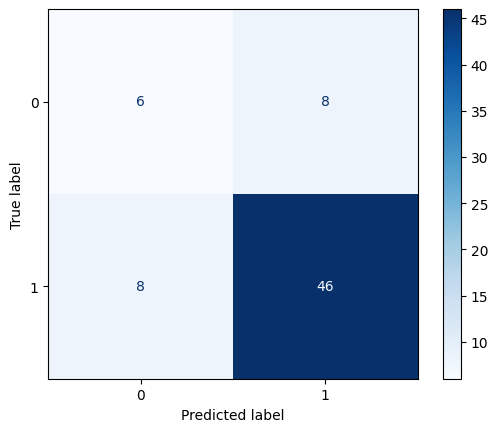

In [ ]:

# Load the data into a Dataset object
data_resource = Dataset.load_from_df(df_resource[["CustID", "resource_id", "rating"]], reader)
# Split the data into training and testing sets
trainset, testset = train_test_split(data_comp, test_size=0.3)

  # Define the similarity options for the algorithm
sim_options = {
      "name": "cosine",
      "user_based": True,
      "k":5
  }
algo = KNNWithMeans(sim_options=sim_options)
# Train the algorithm on the training set
algo.fit(trainset)
# Test the algorithm on the testing set and get the predictions
predictions = algo.test(testset)
third_column = [row[2] for row in testset]
#print(third_column)
predicted_labels = [1 if prediction.est  > 0.5 else 0 for prediction in predictions]
from sklearn.metrics import accuracy_score
A = accuracy_score(third_column,predicted_labels, normalize=True)
print("Accuracy {:.3f}".format(A))
cm = confusion_matrix(third_column, predicted_labels)

cmap = 'Blues' 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)
plt.show()

#resource_id Model and Accuracy

In [ ]:
from surprise.model_selection import KFold

# Load the data into a Dataset object
data_comp = Dataset.load_from_df(df_resource[["CustID", "resource_id", "rating"]], reader)

# Define the similarity options for the algorithm
sim_options = {
    "name": "cosine",
    "user_based": True,
    "k": 25
}
# Create the algorithm
algo = KNNWithMeans(sim_options=sim_options)
# Perform K-Fold cross-validation
kfold = KFold(n_splits=10)
accuracy_scores = []
for trainset, testset in kfold.split(data_comp):
    # Train the algorithm on the training set
    algo.fit(trainset)

    # Test the algorithm on the testing set and get the predictions
    predictions = algo.test(testset)

    third_column = [row[2] for row in testset]

    # Convert ratings to binary labels
    predicted_labels = [1 if prediction.est > 0.5 else 0 for prediction in predictions]

    # Compute accuracy
    accuracy = accuracy_score(third_column, predicted_labels)
    accuracy_scores.append(accuracy)

# Compute the average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores)
print("Average Accuracy: {:.3f}".format(avg_accuracy))

# Retrain the algorithm on the entire dataset
trainset = data_comp.build_full_trainset()
algo.fit(trainset)

# Make predictions on the entire dataset
predictions = algo.test(trainset.build_testset())
# Extract the third column from the dataset for the confusion matrix
third_column = [row[2] for row in trainset.build_testset()]

# Convert ratings to binary labels
predicted_labels = [1 if prediction.est > 0.5 else 0 for prediction in predictions]
# Compute and display the confusion matrix
cm = confusion_matrix(third_column, predicted_labels)
cmap = 'Blues'  
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)
plt.show()

#Type Model and Accuracy

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Average Accuracy: 0.855
Computing the cosine similarity matrix...
Done computing similarity matrix.


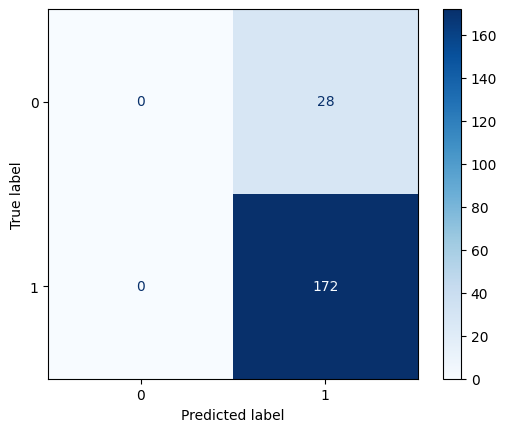

In [ ]:
from surprise.model_selection import KFold

# Load the data into a Dataset object
data_comp = Dataset.load_from_df(df_type[["CustID", "type", "rating"]], reader)

# Define the similarity options for the algorithm
sim_options = {
    "name": "cosine",
    "user_based": True,
    "k":25
}
# Create the algorithm
algo = KNNWithMeans(sim_options=sim_options)

# Perform K-Fold cross-validation
kfold = KFold(n_splits=10)
accuracy_scores = []

for trainset, testset in kfold.split(data_comp):
    # Train the algorithm on the training set
    algo.fit(trainset)

    # Test the algorithm on the testing set and get the predictions
    predictions = algo.test(testset)

    third_column = [row[2] for row in testset]

    # Convert ratings to binary labels
    predicted_labels = [1 if prediction.est > 0.5 else 0 for prediction in predictions]

    # Compute accuracy
    accuracy = accuracy_score(third_column, predicted_labels)
    accuracy_scores.append(accuracy)

# Compute the average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores)
print("Average Accuracy: {:.3f}".format(avg_accuracy))

# Retrain the algorithm on the entire dataset
trainset = data_comp.build_full_trainset()
algo.fit(trainset)

# Make predictions on the entire dataset
predictions = algo.test(trainset.build_testset())

# Extract the third column from the dataset for the confusion matrix
third_column = [row[2] for row in trainset.build_testset()]

# Convert ratings to binary labels
predicted_labels = [1 if prediction.est > 0.5 else 0 for prediction in predictions]

# Compute and display the confusion matrix
cm = confusion_matrix(third_column, predicted_labels)
cmap = 'Blues'  
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)
plt.show()

#Competency Model and Accuracy

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Average Accuracy: 0.850
Computing the cosine similarity matrix...
Done computing similarity matrix.


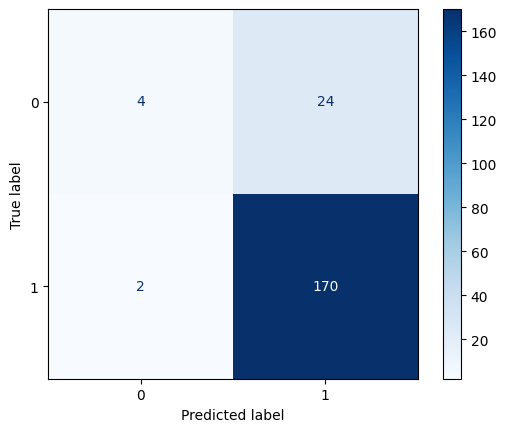

In [ ]:
from surprise.model_selection import KFold

# Load the data into a Dataset object
data_comp = Dataset.load_from_df(df_comp[["CustID", "competency", "rating"]], reader)

# Define the similarity options for the algorithm
sim_options = {
    "name": "cosine",
    "user_based": True,
    "k": 25
}

# Create the algorithm
algo = KNNWithMeans(sim_options=sim_options)

# Perform K-Fold cross-validation
kfold = KFold(n_splits=10)
accuracy_scores = []

for trainset, testset in kfold.split(data_comp):
    # Train the algorithm on the training set
    algo.fit(trainset)

    # Test the algorithm on the testing set and get the predictions
    predictions = algo.test(testset)

    third_column = [row[2] for row in testset]

    # Convert ratings to binary labels
    predicted_labels = [1 if prediction.est > 0.5 else 0 for prediction in predictions]

    # Compute accuracy
    accuracy = accuracy_score(third_column, predicted_labels)
    accuracy_scores.append(accuracy)

# Compute the average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores)
print("Average Accuracy: {:.3f}".format(avg_accuracy))

# Retrain the algorithm on the entire dataset
trainset = data_comp.build_full_trainset()
algo.fit(trainset)

# Make predictions on the entire dataset
predictions = algo.test(trainset.build_testset())

# Extract the third column from the dataset for the confusion matrix
third_column = [row[2] for row in trainset.build_testset()]

# Convert ratings to binary labels
predicted_labels = [1 if prediction.est > 0.5 else 0 for prediction in predictions]

# Compute and display the confusion matrix
cm = confusion_matrix(third_column, predicted_labels)
cmap = 'Blues'  
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder


In [ ]:
dfm = pd.read_csv("/content/drive/MyDrive/Comp /Export2v2v3.csv")

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
dmpz = dfm[['rating','resource_id','type','competency','subCompetency']]

In [ ]:

label_encoder = LabelEncoder()

# Fit the label encoder on the column and transform the strings to numeric labels
dmpz['rating_c'] = label_encoder.fit_transform(dmpz['rating'])
dmpz['resource_id_c'] = label_encoder.fit_transform(dmpz['resource_id'])
dmpz['type_c'] = label_encoder.fit_transform(dmpz['type'])
dmpz['competency_c'] = label_encoder.fit_transform(dmpz['competency'])
dmpz['subCompetency_c'] = label_encoder.fit_transform(dmpz['subCompetency'])


dmpzf = dmpz[['rating_c','resource_id_c','type_c','competency_c','subCompetency_c']]

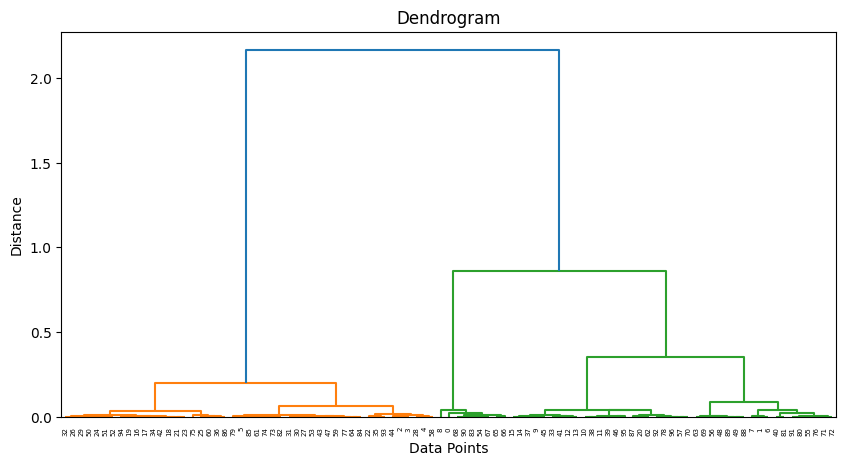

In [ ]:
# Calculate the pairwise distance matrix
dist_matrix = pdist(dmpzf.values, metric='cosine')

# Perform hierarchical clustering
linkage_matrix = linkage(dist_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

n_clusters = 10  # Set the desired number of clusters
